In [4]:
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from typing import List, Tuple
from collections import Counter, defaultdict
from nltk import pos_tag, word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image
import json
import wikipedia

In [22]:
# POS that should not be included 
[x[1] for x in pos_tag([',','.','you','not','how','what','all','and','did','your','can','nor','am','did','your'])]

[',',
 '.',
 'PRP',
 'RB',
 'WRB',
 'WP',
 'DT',
 'CC',
 'VBD',
 'PRP$',
 'MD',
 'CC',
 'VBP',
 'VBD',
 'PRP$']

In [6]:
def _mmr(doc_embedding: np.ndarray,
        word_embeddings: np.ndarray,
        words: List[str],
        top_n: int = 5,
        diversity: float = 0.8) -> List[Tuple[str, float]]:

    # Extract similarity within words, and between words and the document
    word_doc_similarity = cosine_similarity(word_embeddings, doc_embedding)
    word_similarity = cosine_similarity(word_embeddings)

    # Initialize candidates and already choose best keyword/keyphras
    keywords_idx = [np.argmax(word_doc_similarity)]
    candidates_idx = [i for i in range(len(words)) if i != keywords_idx[0]]

    for _ in range(top_n - 1):
        # Extract similarities within candidates and
        # between candidates and selected keywords/phrases
        candidate_similarities = word_doc_similarity[candidates_idx, :]
        target_similarities = np.max(word_similarity[candidates_idx][:, keywords_idx], axis=1)

        # Calculate MMR
        mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1, 1)
        mmr_idx = candidates_idx[np.argmax(mmr)]

        # Update keywords & candidates
        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)

    return [(words[idx], round(float(word_doc_similarity.reshape(1, -1)[0][idx]), 4)) for idx in keywords_idx]


def scatter_keywords(model, keywords, document, diversity, top_ratio):
    document_embedding = model.encode(document).reshape(1,-1)
    keyword_embeddings = model.encode(keywords)
#     print(len(keywords))
    if len(keywords) == 1:
        keyword_embeddings = keyword_embeddings.reshape(1,-1)
    
    top_n = len(keywords)
    scattered_keyword_value_pair = _mmr(document_embedding, keyword_embeddings, keywords, top_n, diversity)
    scattered_keywords = [x[0] for x in scattered_keyword_value_pair]
    return scattered_keyword_value_pair


def extract_keywords(model, ablist, keyword_ratio=1, diversity=0.9):
    count = 0
    NPOS = [',', '.', 'PRP', 'RB', 'WRB', 'WP', 'DT', 'your', 'can', 'nor', 'am', 'did', 'PRP$', 'CC']
    lemmatizer = WordNetLemmatizer()
    final_cnt = Counter({})
    for ab in ablist:
        tokenized_text_with_punc = word_tokenize(ab.lower())
        tagged_text = pos_tag(tokenized_text_with_punc)

        candidate_phrases = [x[0] for x in tagged_text if (x[1] not in NPOS)]
        # scatter the keywords, assign scores to these keywords by scaling the document
        scattered_keyword_value_pair = scatter_keywords(model, candidate_phrases, ab, diversity=diversity, top_ratio=keyword_ratio)
        current_keyword_score_dict_scaled = defaultdict(lambda:0,{})
        for k, v in scattered_keyword_value_pair:
            k_lem = lemmatizer.lemmatize(k)
            current_keyword_score_dict_scaled[k_lem] += v
        current_keyword_score_dict_scaled = dict(current_keyword_score_dict_scaled)
        current_cnt = Counter(current_keyword_score_dict_scaled)
        final_cnt = final_cnt + current_cnt

    unprocessed_keyword_score_dict = dict(final_cnt)
    return unprocessed_keyword_score_dict

In [7]:
def create_wordcloud(plot):
    model = SentenceTransformer('distilbert-base-nli-mean-tokens')
    ks_dict = extract_keywords(model, plot)
    
    mask = np.array(Image.open("mask1.jpg"))
    shakespeare = ImageColorGenerator(mask,default_color=(0,0,0))    
    
    wordcloud = WordCloud(width=900,height=500, max_words=10000, mask=mask, relative_scaling=0.3,normalize_plurals=False).generate_from_frequencies(ks_dict)
    wordcloud = wordcloud.recolor(color_func=shakespeare, random_state=3)
    wc_array = wordcloud.to_array()
    plt.figure(figsize = (8,8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
    return ks_dict, wc_array


In [8]:
def interpret_dict(d):
    lis = list(zip(list(d.keys()),list(d.values())))
    lis = sorted(lis,key=lambda x:x[1],reverse=True)
    return lis

In [9]:
with open('./resources/movie_ids.json', 'r') as f:
    id_lis = json.loads(f.read())   
with open('./resources/movie_names.json', 'r') as f:
    name_lis = json.loads(f.read())   

In [10]:
plots = []
for pageid in id_lis:
    pg = wikipedia.page(pageid=pageid)
    if pg.section('Plot') != '':
        plots.append(pg.section('Plot'))

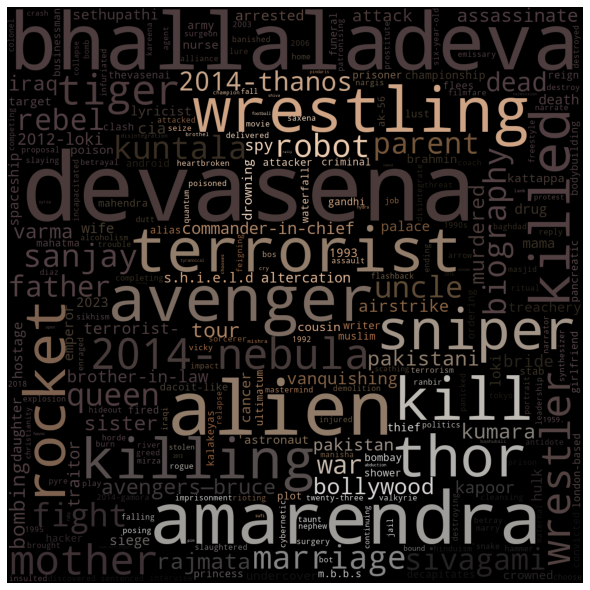

In [20]:
d, wc = create_wordcloud(plots)

Baahubali 2: The Conclusion


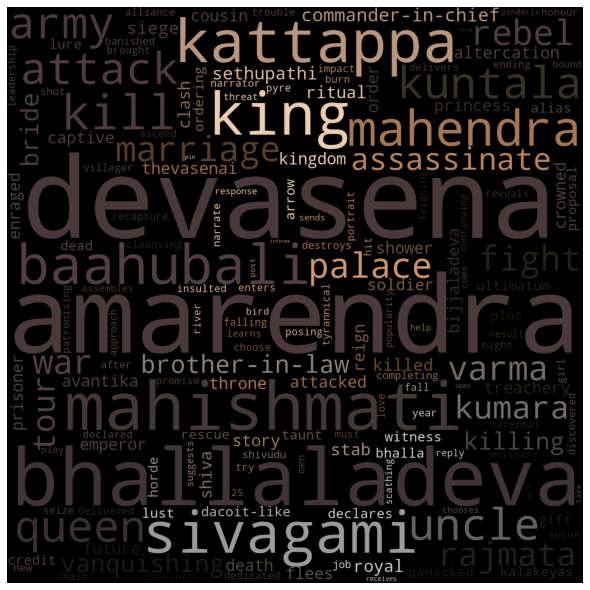

Baahubali: The Beginning


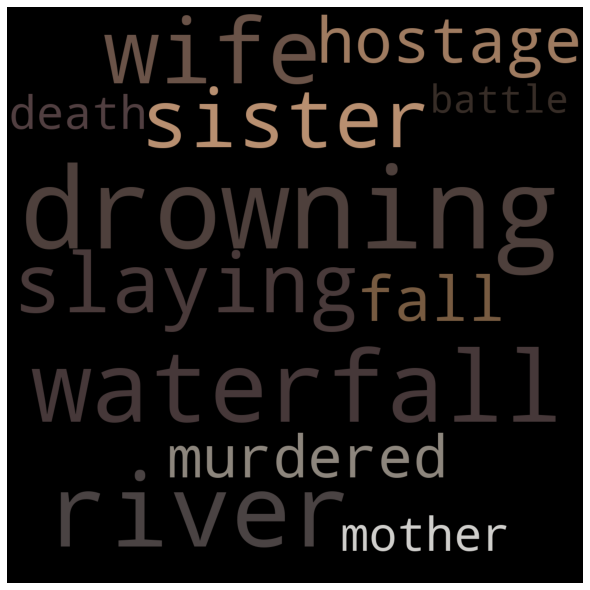

2.0 (film)


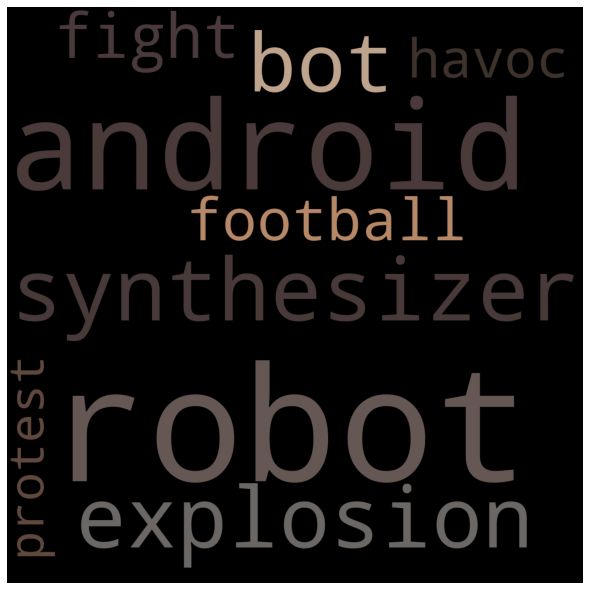

Dangal (film)


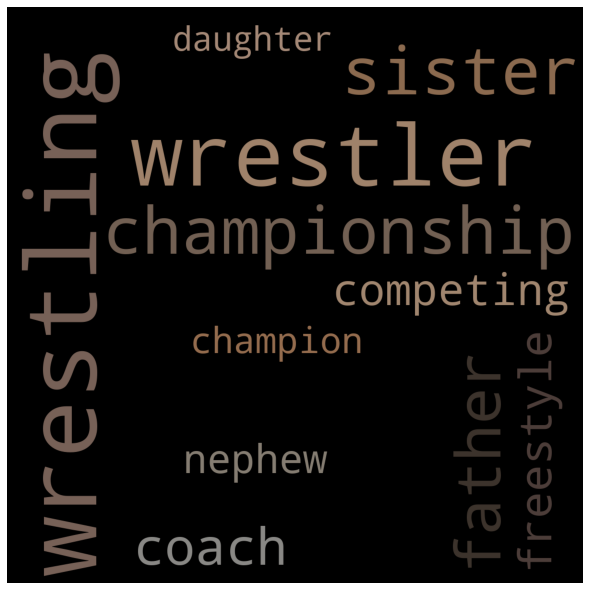

Avengers: Endgame


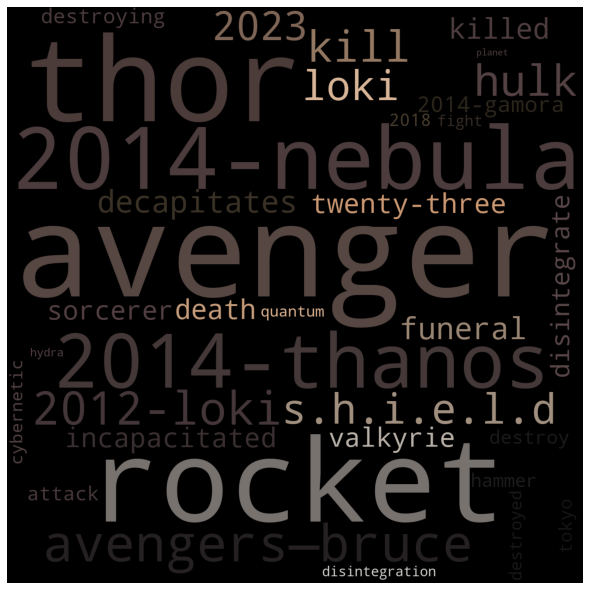

Sanju


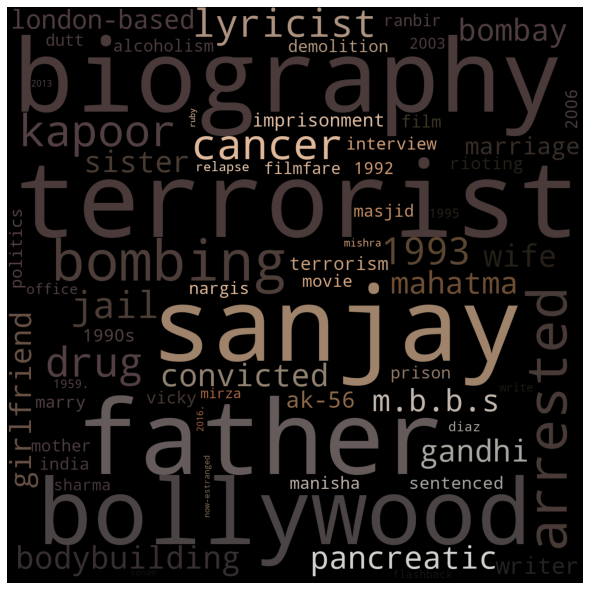

PK (film)


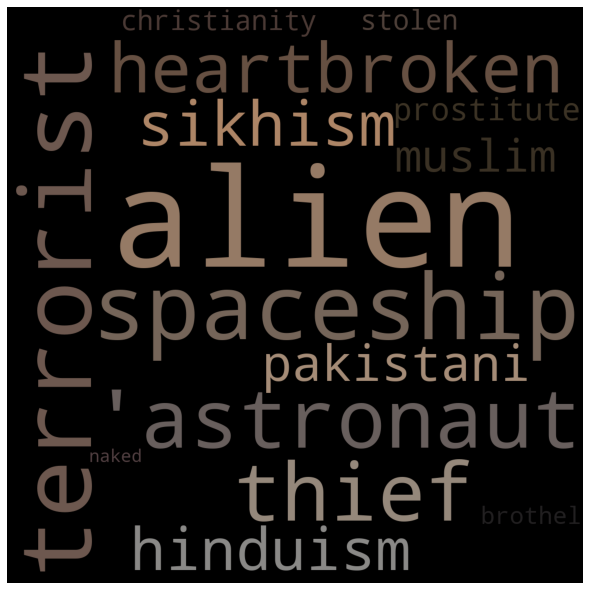

Tiger Zinda Hai


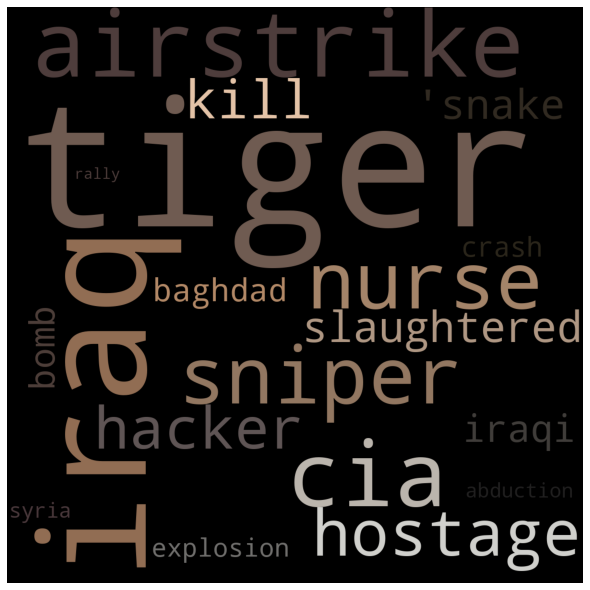

Bajrangi Bhaijaan


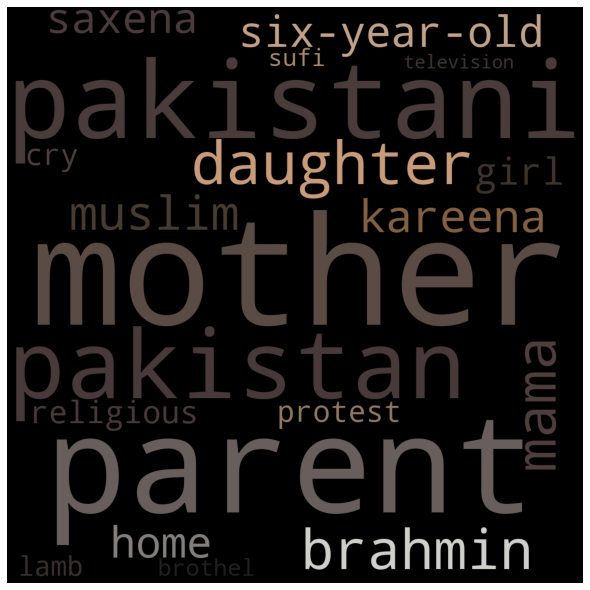

War (2019 film)


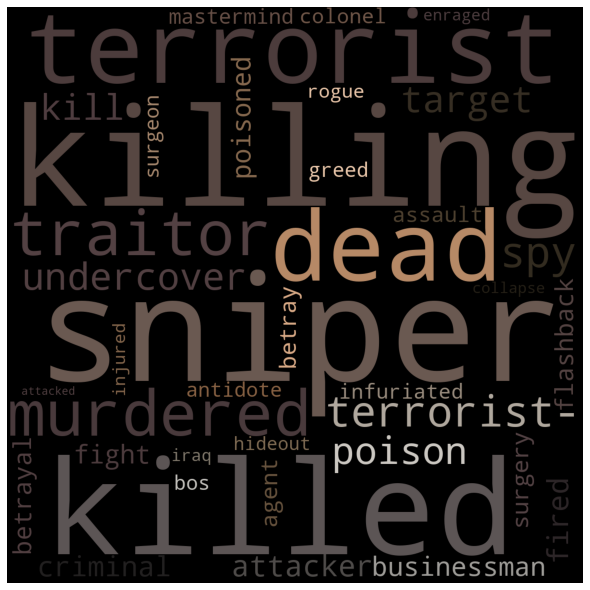

In [21]:
for idx, plot in enumerate(plots):
    print(name_lis[idx])
    create_wordcloud([plot])